In [1]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import models

from src.resnet_yolo import resnet50
from yolo_loss import YoloLoss
from src.dataset import VocDetectorDataset, get_train_test
from src.eval import evaluate
from src.predict import predict_image
from src.config import VOC_CLASSES, COLORS, VOC_IMG_MEAN

import matplotlib.pyplot as plt
import collections

train_dataset, test_dataset = get_train_test()
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)

load_network_path = '/home/albyyuggle/Code/CS498/FP/checkpoints/detector3.pth'
pretrained = True

device = 'cuda'
# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

net.eval()


load_network_path = '/home/albyyuggle/Code/CS498/FP/checkpoints/detector2_late.pth'
pretrained = True

device = 'cuda'
# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net2 = resnet50().to(device)
    net2.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net2 = resnet50(pretrained=pretrained).to(device)

net2.eval()

Initializing dataset
Initializing dataset
Loading saved network from /home/albyyuggle/Code/CS498/FP/checkpoints/detector3.pth
Loading saved network from /home/albyyuggle/Code/CS498/FP/checkpoints/detector2_late.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

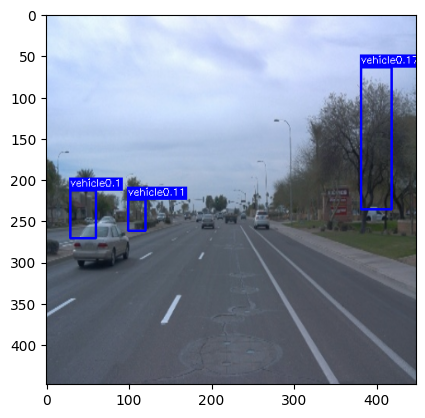

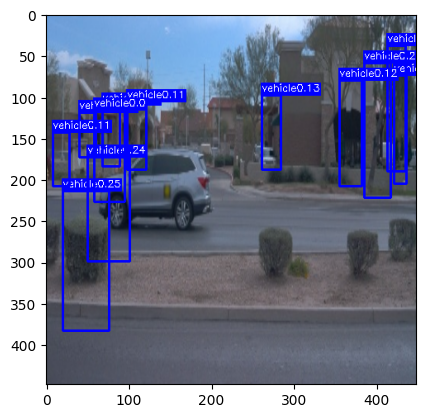

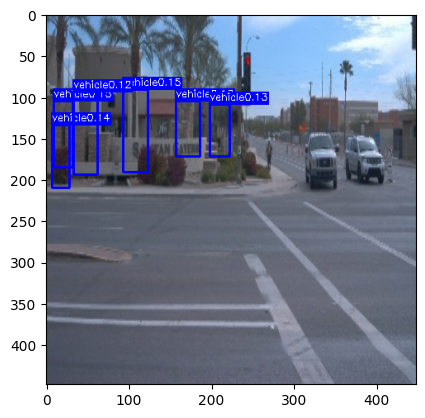

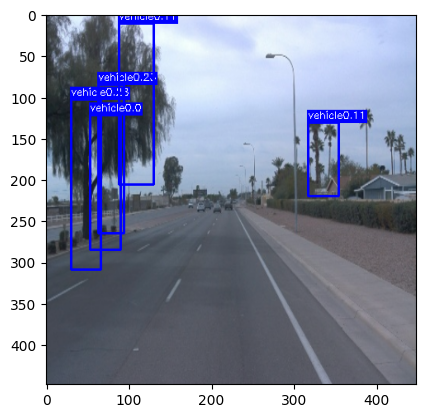

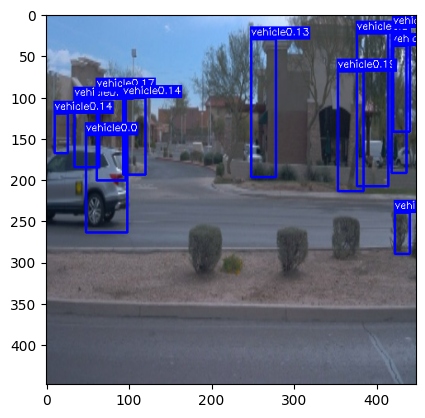

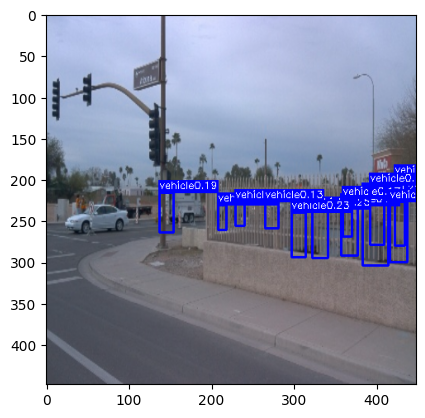

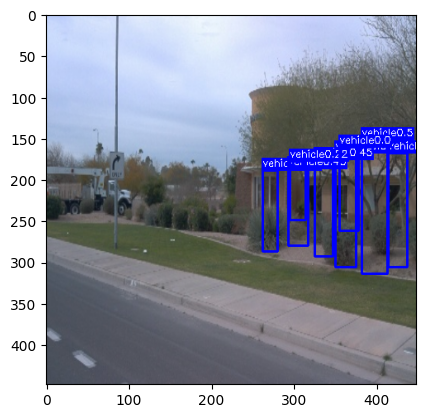

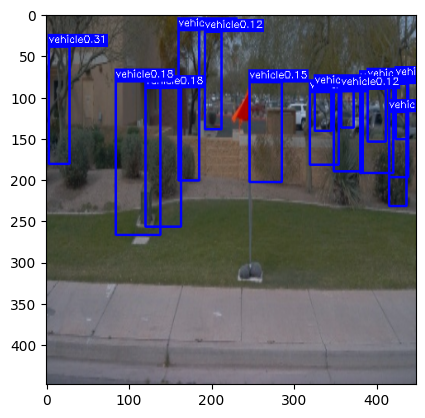

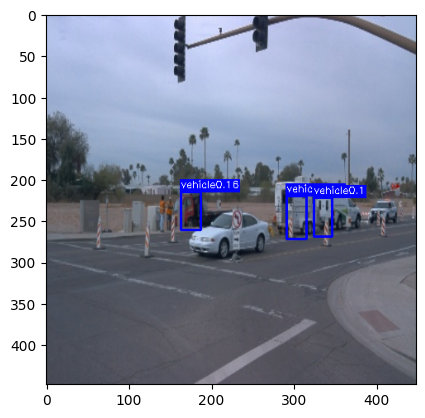

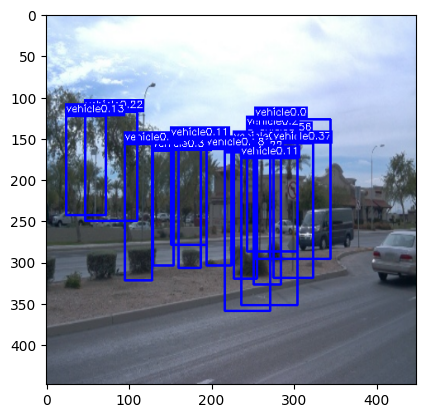

In [2]:
import copy
import torchvision
for i, data in enumerate(test_loader):
    #print("iter", i)
    with open('./mAP/input/detection-results/'+str(i)+'.txt', 'w+') as predfile:
        with open('./mAP/input/ground-truth/'+str(i)+'.txt', 'w+') as truthfile:
            images, target_boxes, target_cls, has_object_map, dimg, bxs, lbls, fname = data
            img_copy = cv2.imread(fname[0], cv2.IMREAD_COLOR)
            img_copy = cv2.resize(img_copy, (448, 448))
            dimg = dimg.type(torch.FloatTensor)

            bxs = bxs[0]
            lbls = lbls[0]
            num_obj = len(bxs)

            for j in range(num_obj):
                x1, y1, x2, y2 = bxs[j]
                class_name = VOC_CLASSES[int(lbls[j].item())]
                truthfile.write("{} {} {} {} {}\n".format(class_name, x1, y1, x2, y2))

            image = images[0].permute(1,2,0).cpu().numpy()
            
            dimg = dimg[0].permute(1,2,0).cpu().numpy()
            result = predict_image(net, image, image_name = i)
            result2 = predict_image(net2, dimg, image_name = i)
            all_boxes = []
            all_class = []
            all_prob = []
            for (
                (x1, y1),
                (x2, y2),
                class_name,
                image_id,
                prob,
            ) in result:  # image_id is actually image_path
                all_boxes.append([x1, y1, x2, y2])
                all_class.append(class_name)
                all_prob.append(prob)
            for (
                (x1, y1),
                (x2, y2),
                class_name,
                image_id,
                prob,
            ) in result2:  # image_id is actually image_path
                all_boxes.append([x1, y1, x2, y2])
                all_class.append(class_name)
                all_prob.append(prob)

            all_boxes2 = np.array(copy.deepcopy(all_boxes))
            all_boxes = torch.Tensor(all_boxes)
            all_prob = torch.Tensor(all_prob)
            all_class = np.array(all_class)
            locs = torchvision.ops.nms(all_boxes, all_prob, 0.4).numpy()
            #print(locs)
            all_boxes = all_boxes.numpy()[locs, :]
            all_prob = all_prob.numpy()[locs]
            all_class = all_class[locs]

            for j in range(len(all_boxes)):
                x1, y1, x2, y2 = all_boxes2[j].astype(np.int64)
                
                class_name = all_class[j]
                prob = all_prob[j]

                predfile.write("{} {} {} {} {} {}\n".format(class_name, 0.9, x1, y1, x2, y2))
                color = COLORS[VOC_CLASSES.index(class_name)]
                cv2.rectangle(img_copy, (x1,y1), (x2,y2), color, 2)
                label = class_name + str(round(prob, 2))
                text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
                p1 = (x1, y1 - text_size[1])
                cv2.rectangle(img_copy, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                            color, -1)
                cv2.putText(img_copy, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)
            
            if i % 50 == 0:
                plt.imshow(img_copy)
                plt.show()    


In [3]:
0.00% = pedestrian AP 
0.18% = vehicle AP 
mAP = 0.09%

SyntaxError: invalid syntax (3922066364.py, line 1)